## Predictive Modeling: Using Regression models to predict price of used cars.
This project aims to show the process of creating Machine Learning models based on Simple, Multiple and Polynomial Regressions.
In this project, R2 is used to evaluate the performance of the models. Pearson Coeficient's P-Value of <= 0.05 rejects the null hypotesis.

In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output

In [12]:
def PrepData(pathfile,carmodelname,target): ##remove nulls in price
    df = pd.read_csv(pathfile)
    df['car_name'] = df['manufacturer_name'] + '-' + df['model_name']
    df = df[df['car_name'].isin([carmodelname])].reset_index(drop=True).drop(['feature_1','feature_2','feature_3','feature_4','feature_5','feature_6','feature_7','feature_8','feature_9','duration_listed','engine_has_gas','engine_type','has_warranty','is_exchangeable','location_region','number_of_photos','body_type','up_counter','feature_0','manufacturer_name','model_name','car_name'],axis=1)
    df = df[df['price_usd'] > 0]
    for column in df.columns:
        if (df[column] == df[column][0]).all():
            df.drop(columns=column,inplace=True)
    TargetVar = df[target]
    df.drop(columns=[target],axis=1,inplace=True)
    df.insert(0,target,TargetVar)
    dfobject = df.select_dtypes(include='object')
    df = df.select_dtypes(exclude='object')
    mergeddf = pd.merge(df,Dummies(dfobject),left_index=True,right_index=True)                                                            
    return dfobject, df, mergeddf

def Dummies(df):
    return pd.concat([df, pd.get_dummies(df[list(df)])],axis=1).drop(df[list(df)],axis=1)

def BoxplotObjects(df,dftarget): ## Show counts on plot ##better show car colors
    fig, axs = plt.subplots(ncols=len(list(df)), figsize=(16,4),sharey=True)
    t = 0
    for c in list(df):
        sns.boxplot(x=df[c],y=dftarget[Y],data=df, ax=axs[t])
        t += 1
    return

#Pearson coefficient calculation
def CoefPearson(df):
    lcoef = []
    lp = []
    for col in list(df.columns):
        coef, p = stats.pearsonr(df[col],df[Y])
        lcoef.append(coef)
        lp.append(round(p,3))
    return pd.DataFrame(lcoef).merge(pd.DataFrame(lp),on=df.columns).rename(columns={'key_0':'IndependentVar','0_x':'PearsonCoef','0_y':'P-Value'}).drop([0]).reset_index(drop=True)

#Listing n independent variables with p <= 0.05
def NLargAbsCoef(df,n):
    df = CoefPearson(df)
    df = df[df['P-Value'] <= 0.05].reset_index(drop=True).loc[df['PearsonCoef'].abs().nlargest(n,keep='first').index]
    return list(df['IndependentVar'])

#Listing all indepedent variables with p <= 0.05
def AllCoef(df):
    df = CoefPearson(df)
    df = df[df['P-Value'] <= 0.05].reset_index(drop=True)
    return list(df['IndependentVar'])

#Simple Linear Regression Model and Plot
def SLRModelandPlot():
    x = cardf[[NLargAbsCoef(cardf,1)[0]]].values
    m = LinearRegression().fit(x,TargetCol)
    fig, axs = plt.subplots(ncols=2, figsize=(16,4))
    ax0 = sns.regplot(x=x,y=TargetCol,data=cardf,ax=axs[0])
    ax1 = sns.residplot(x=x,y=TargetCol,data=cardf,ax=axs[1])
    ax0.set_ylim(0,)
    ax0.set_xlim(x.min(),)
    print('Simple Linear Regression Model Equation:\n',m.intercept_,'+',float(m.coef_),'*',Y)
    return m,x

#Multiple Linear Regression Model and Plot
def MLRModelandPlot(): #adapt to get max num of var and better show model equation
    x = cardf[AllCoef(cardf)].values
    m = LinearRegression().fit(x,TargetCol)
    print("Intercept:",m.intercept_)
    print("Coefs:",list(m.coef_))
    plt.figure(figsize=(16,4))
    ax1 = sns.kdeplot(TargetCol, color="r", label="Actual Value")
    sns.kdeplot(m.predict(x), color="b", label="Predicted Values", ax=ax1)
    plt.title('Actual (red) vs Predicted (blue) Price')
    plt.xlabel('Price')
    plt.ylabel('Proportion of Cars')
    plt.xlim(0,)
    plt.show()
    plt.close()
    return x,m

#Polynomial Regression Model and Plot
def PlotPR(degrees): #adapt to get best degree
    x = cardf[NLargAbsCoef(cardf,1)[0]].values
    m = np.poly1d(np.polyfit(x, TargetCol, degrees))
    x_new = np.linspace(x.min(),x.max())
    y_new = m(x_new)
    print('Polynomial Regression Model Equation:\n',m)
    plt.plot(x, TargetCol, '.', x_new, y_new, '-')
    ax = plt.gca()
    ax.set_facecolor((0.898, 0.898, 0.898))
    fig = plt.gcf()
    plt.show()
    plt.close()
    return x,m

In [13]:
def car_selector():
    df = pd.read_csv('../PredictiveModelingRegression/cars.csv')
    dropdown_manufacturer = widgets.Dropdown(options = sorted(list(set(df['manufacturer_name']))))
    output = widgets.Output()

    def output_by_manufacturer(manufacturer):
        with output:
            IPython.display.clear_output(wait=True)
            output_data = df[df['manufacturer_name'] == manufacturer]
            display(output_data)     

    def dropdown_state_eventhandler(change):
            display(input_widgets)
            output_by_manufacturer(change.new) 

    dropdown_manufacturer.observe(dropdown_state_eventhandler, names='value')
    input_widgets = widgets.HBox([dropdown_manufacturer])
    display(input_widgets,output)

In [14]:
car_selector()

Output()

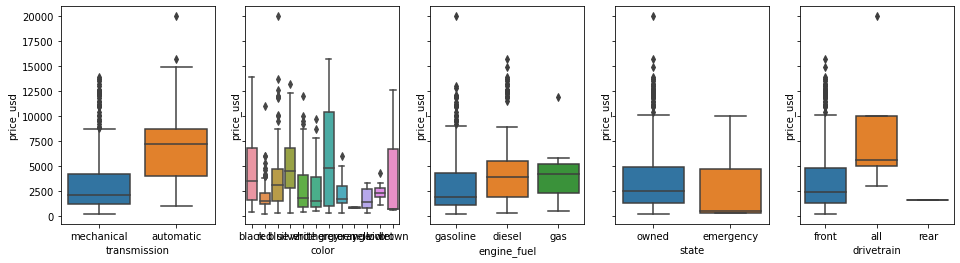

In [15]:
pf = '../PredictiveModelingRegression/cars.csv' #pathfile of the dataset
#list(set(pd.read_csv('../PredictiveModelingRegression/cars.csv')['model_name'])) <-- List of car models
carmodel = 'Volkswagen-Golf' # Car model to predict
Y = 'price_usd' # Y is the name of the column with dependent (target) variable
#Pipeline more
dfobj, dfnum, cardf = PrepData(pf,carmodel,Y)
BoxplotObjects(dfobj, dfnum)
TargetCol = cardf[Y]

Simple Linear Regression Model Equation:
 -687740.0671526314 + 346.0436035430563 * price_usd


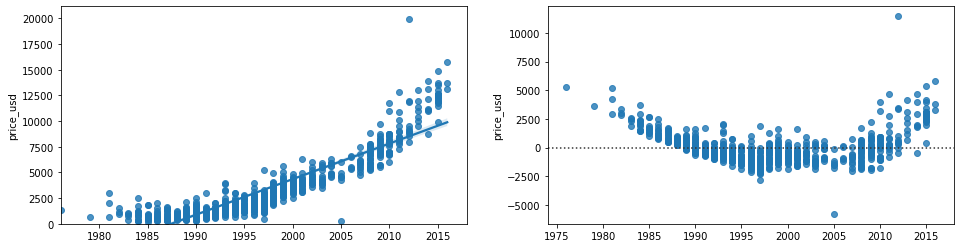

In [16]:
slrm,slrx = SLRModelandPlot()

Intercept: -630565.3149226797
Coefs: [-0.0003170814503313186, 318.94396060375624, -1178.005760944823, 426.3759665854557, -426.37596658545783, 228.33381167292768, -97.81654735937887, 898.1080795880218, -166.67513906193707, -199.7386030585114, -134.49567191730236, 715.2565320325081, 102.36729614906815, 2290.7657913387434, -1026.1180113779137]


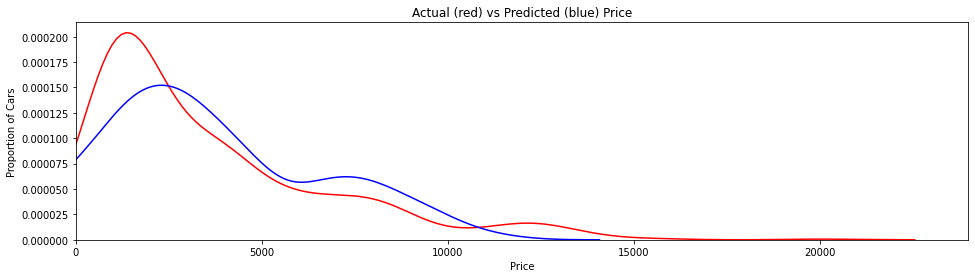

In [17]:
mlrx, mlrm = MLRModelandPlot()

Polynomial Regression Model Equation:
          4       3             2
0.01755 x - 140 x + 4.191e+05 x - 5.576e+08 x + 2.781e+11


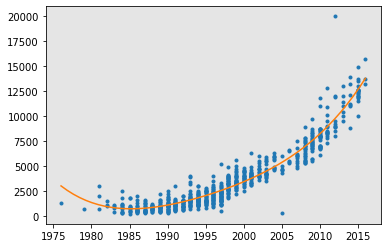

In [18]:
prx, prm = PlotPR(4)

In [19]:
#R2 calculation
def R2(realY,predictY):
    return r2_score(realY,predictY)

#Comparison of best model by R2 criteria
def ModelComparison():
    md = ['Simple Linear Regression','Multiple Linear Regression','Polynomial Regression']
    preds = [slrm.predict(slrx),mlrm.predict(mlrx),prm(prx)]
    bestr2 = 0
    for pred, q in zip(list(preds), md):
        r2 = R2(TargetCol,pred)
        print(q,'R2:',r2)
        if r2 > bestr2:
            bestr2 = r2
            bestq = q
    print('\nBest model by R2 is',bestq,'with R2 of',bestr2)

In [20]:
ModelComparison()

Simple Linear Regression R2: 0.8134058215471239
Multiple Linear Regression R2: 0.8378731807182898
Polynomial Regression R2: 0.9223584199254606

Best model by R2 is Polynomial Regression with R2 of 0.9223584199254606
